In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 2. Single particle tracking



## 1. Setup

Imports the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from deeptrack.scatterers import Sphere
from deeptrack.optics import Brightfield, IlluminationGradient
from deeptrack.noises import Poisson
from deeptrack.math import NormalizeMinMax
from deeptrack.generators import Generator
from deeptrack.augmentations import FlipLR, FlipUD, FlipDiagonal, PreLoad
from deeptrack.features import ConditionalSetFeature
from deeptrack.models import Convolutional


IMAGE_SIZE = 48

## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 48 by 48 pixel images, containing a single particle each. The particles are simulated as spheres with a radius between 0.5 microns and 1 micron, and a refractive index between 1.4 and 1.6. Its position in the camera plane is constrained to be within the image, and is sampled with a normal distribution with standard deviation of 5 pixel units in along the axis normal to the camera plane. 

In [3]:
particle = Sphere(
    position=lambda: np.random.rand(2) * IMAGE_SIZE,
    z=lambda: np.random.randn() * 5,
    radius=lambda: 0.5e-6 + np.random.rand() * 0.5e-6,
    refractive_index=lambda: 1.4 + np.random.rand() * 0.2,
    position_unit="pixel",
)

The particle is imaged using a brightfield microscope with NA between 0.6 and 0.9, illuminating laser wavelength between 400 and 700 nm, a magnification between 4 and 10, and a random illumination gradient.

In [4]:
gradient = IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 3e-3,
    constant=lambda: np.random.rand() * 1
)

optics = Brightfield(
    NA=lambda: 0.6 + np.random.rand() * 0.3,
    wavelength=lambda: 400e-9 + np.random.rand() * 300e-9,
    resolution=1e-6,
    magnification=lambda: 4 + np.random.rand() * 6,
    padding=(32, 32, 32, 32),
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    illumination=gradient
)

The noise is simulated as poisson noise with an signal to noise ratio between 10 and 50. The image is finally normalized by rescaling it to values between 0 and 1.

In [5]:
noise = Poisson(
    snr=lambda: 10 + np.random.rand() * 40
)

normalization = NormalizeMinMax(
    min=0,
    max=1,
)

We now define how these objects combine. Calling the optics object with the particle object tells DeepTrack to that is should image that particle using that optical device. We define an augmented version of `imaged_particle` which will increase the speed of the training. To bypass this augmentation during validation we create a conditional feature, which calls `imaged_particle` directly if `skip_augmentation=True`.

Finally we add in the noise and the normalization.

In [6]:
imaged_particle = optics(particle)

augmented_imaged_particle = PreLoad(
    FlipLR(FlipUD(FlipDiagonal(imaged_particle))),
    load_size=1,
    updates_per_reload=4)

conditional_imaged_particle = ConditionalSetFeature(
    on_false=augmented_imaged_particle,  
    on_true=imaged_particle,
    condition="skip_augmentations"
)

dataset = conditional_imaged_particle + noise + normalization

### 2.2 Defining the training label

The training label is extracted directly frm the image as the `position` property divided by the image size, such that the posible values are contained within 0 and 1.

In [7]:
def get_label(image):
    return np.array(image.get_property("position")) / IMAGE_SIZE

### 2.3 Visualizing the dataset

We resolve and show 16 images, with a green circle indicating the particle position.

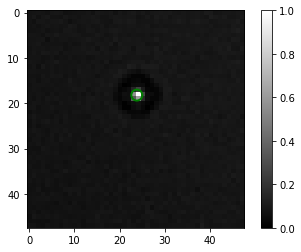

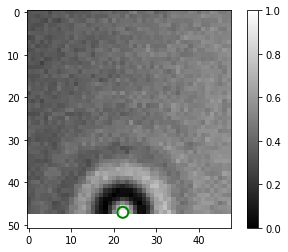

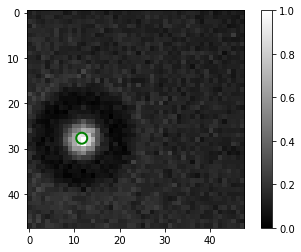

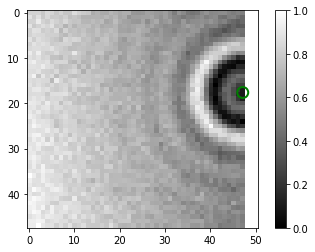

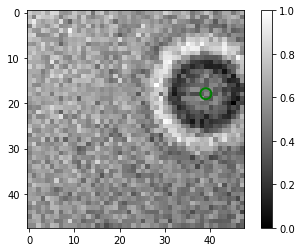

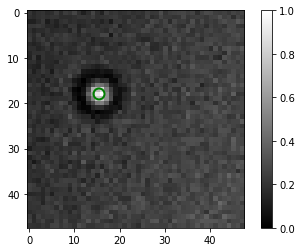

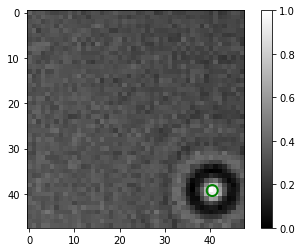

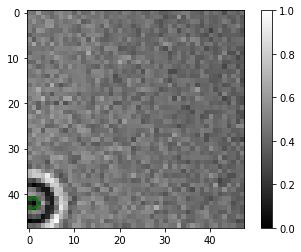

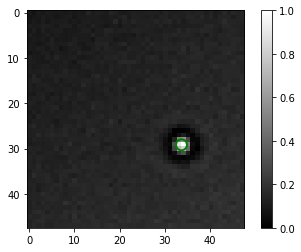

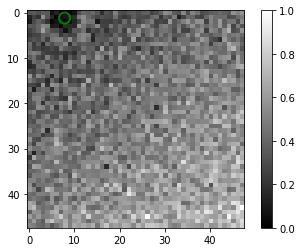

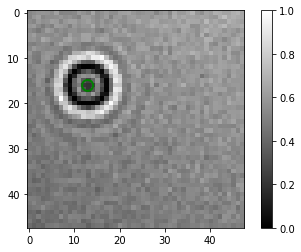

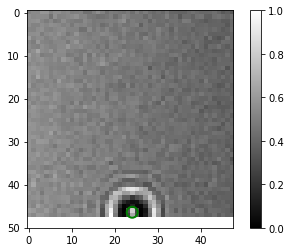

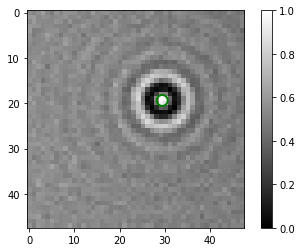

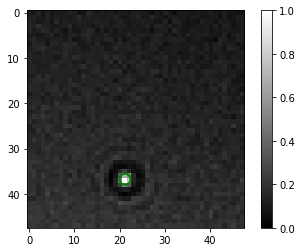

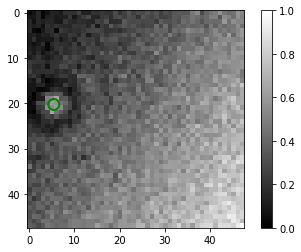

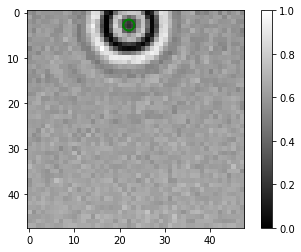

In [8]:
NUMBER_OF_IMAGES = 16

for _ in range(NUMBER_OF_IMAGES):
    dataset.update()
    image_of_particle = dataset.resolve(skip_augmentations=True)
    position_of_particle = get_label(image_of_particle) * IMAGE_SIZE
                                     
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    
    plt.colorbar()
    plt.scatter(position_of_particle[1], position_of_particle[0], s=120, facecolors='none', edgecolors="g", linewidth=2)
    plt.show()
    

## 3. Defining the network

The network used is a Convolutional network, with a the pixel error as loss.

In [30]:
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers
def pixel_error(T, P):
    return K.mean(K.sqrt(K.sum(K.square(T - P), axis=-1))) * IMAGE_SIZE

model = Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    conv_layers_dimensions=(16, 32, 64, 128),
    dense_layers_dimensions=(32, 32),
    dropout=(0.15, 0.15),
    number_of_outputs=2,
    loss=pixel_error,
    metrics=["mse"],
    optimizer=optimizers.Adam(lr=0.001, amsgrad=True)
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 46, 46, 16)        160       
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 46, 46, 16)        0         
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 23, 23, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 21, 21, 32)        4640      
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 21, 21, 32)        0         
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 10, 10, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 8, 8, 64)         

## 4. Training the network

There are two main ways to provide the model with training data. If the data is too large to be contained in memory, we provide a generator in `deeptrack.Generators` to continuously generate new training data. Here, the images are small enough to be contained in memory, which is why we instead create the full training set in advance. This is significantly faster than generating on the fly, since tensorflow is allowed to optimize the data transfer.

In [31]:
training_set_size = int(2e5)
validation_set_size = 2000

training_set = [dataset.update().resolve() for _ in range(training_set_size)]
training_labels = [get_label(image) for image in training_set]

validation_set = [dataset.update().resolve(skip_augmentations=True) for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

h = model.fit(np.array(training_set), 
              np.array(training_labels),
              validation_data=(np.array(validation_set), 
                               np.array(validation_labels)),
              epochs=25)

Epoch 1/50
6250/6250 [==============================] - 41s 6ms/step - loss: 1.8219 - mse: 0.0031 - val_loss: 1.0453 - val_mse: 0.0012
Epoch 2/50
6250/6250 [==============================] - 69s 11ms/step - loss: 0.7459 - mse: 3.1406e-04 - val_loss: 0.8087 - val_mse: 9.5807e-04
Epoch 3/50
6250/6250 [==============================] - 69s 11ms/step - loss: 0.6155 - mse: 2.3013e-04 - val_loss: 0.7163 - val_mse: 9.0106e-04
Epoch 4/50
6250/6250 [==============================] - 75s 12ms/step - loss: 0.5516 - mse: 1.8948e-04 - val_loss: 0.7133 - val_mse: 8.3506e-04
Epoch 5/50
6250/6250 [==============================] - 82s 13ms/step - loss: 0.5120 - mse: 1.6411e-04 - val_loss: 0.7008 - val_mse: 9.5735e-04
Epoch 6/50
6250/6250 [==============================] - 84s 13ms/step - loss: 0.4839 - mse: 1.4752e-04 - val_loss: 0.6333 - val_mse: 8.2786e-04
Epoch 7/50
6250/6250 [==============================] - 87s 14ms/step - loss: 0.4628 - mse: 1.3417e-04 - val_loss: 0.6185 - val_mse: 8.6247e-04
E

KeyboardInterrupt: 

## 5. Evaluating the network

### 5.1 Loss vs validation
We plot the metrics evaluated on the training data compared to the validation data to spot potential overtraining. 

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(h.history["loss"], 'g')
plt.plot(h.history["val_loss"], 'r')
plt.legend(["loss", "val_loss"])
plt.plot()

### 5.2 Prediction vs actual

We show a few images, with the true position as a green circle, and the predicted position as a blue cross.

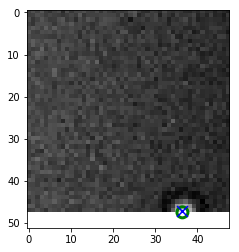

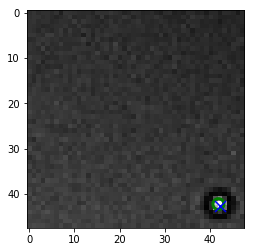

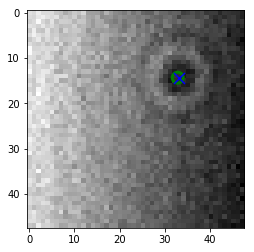

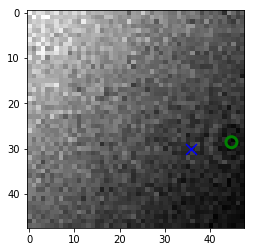

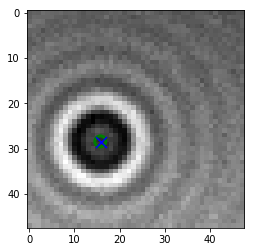

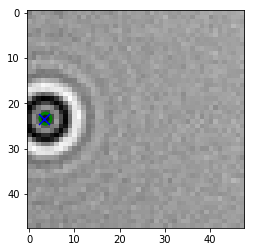

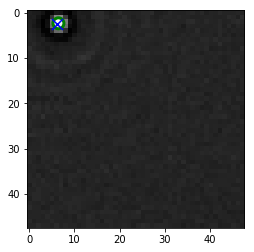

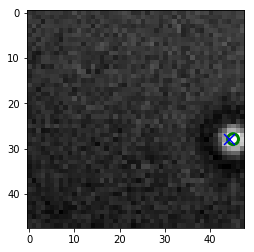

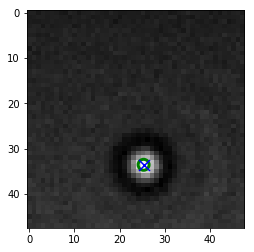

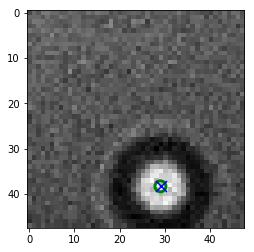

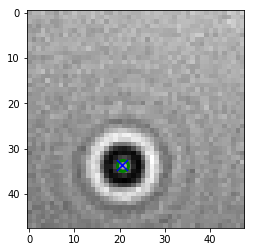

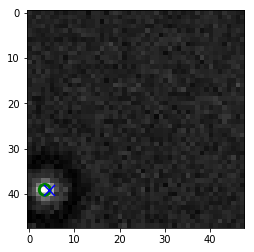

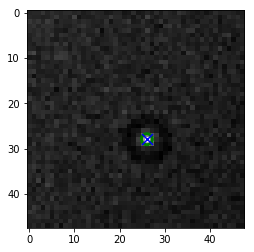

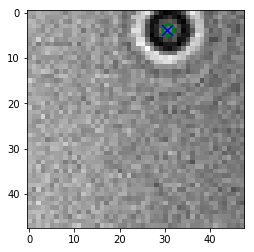

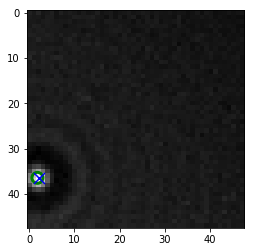

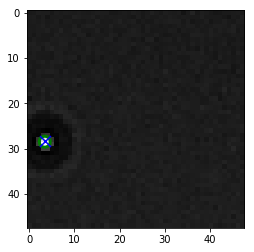

In [32]:
NUMBER_OF_IMAGES = 16

for _ in range(NUMBER_OF_IMAGES):
    dataset.update()
    image_of_particle = dataset.resolve(skip_augmentations=True)
    position_of_particle = get_label(image_of_particle) * IMAGE_SIZE
    prediction = model.predict(np.array([image_of_particle])) * IMAGE_SIZE
    
    plt.imshow(image_of_particle[:, :, 0], cmap="gray")
    plt.scatter(position_of_particle[1], position_of_particle[0], marker='o', s=120, facecolors='none', edgecolors="g", linewidth=3)
    plt.scatter(prediction[0, 1], prediction[0, 0], marker='x', s=120, c="b")
    plt.show()

### 5.3 Prediction vs actual

We show the prediction of each output versus the ground truth

In [ ]:
validation_prediction = model.predict(np.array(validation_set))
labels = np.array(validation_labels)
for col in range(validation_prediction.shape[-1]):
    label_col = labels[:, col]
    prediction_col = validation_prediction[:, col]
    plt.scatter(label_col, prediction_col, alpha=0.1)
    
    plt.plot([np.min(label_col), np.max(label_col)], 
             [np.min(label_col), np.max(label_col)], c='k')
    plt.show()

### 5.3 Prediction vs property value

We show the the pixel error as a function of some properties.

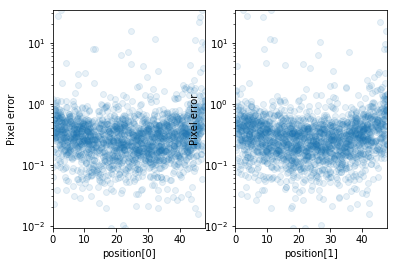

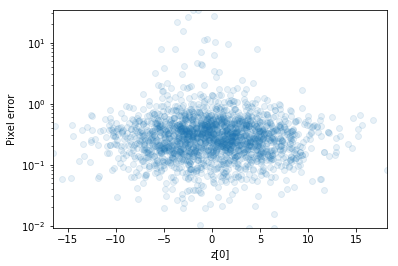

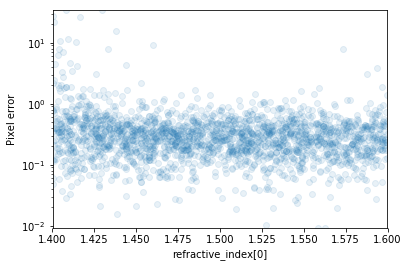

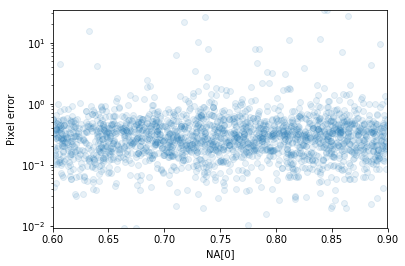

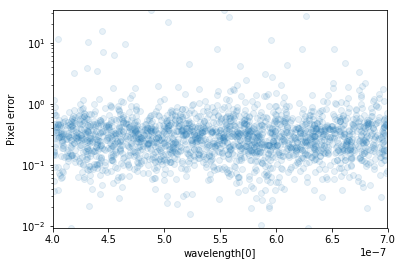

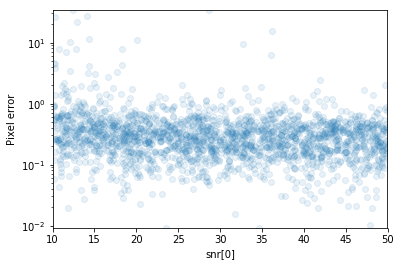

In [50]:
properties = ["position", "z", "refractive_index", "NA", "wavelength", "snr"]

validation_prediction = model.predict(np.array(validation_set))
validation_error = np.sqrt(np.sum(np.square(validation_labels - validation_prediction), axis=-1)) * IMAGE_SIZE

for property_name in properties:
    property_values = np.array([image.get_property(property_name) for image in validation_set])
    if property_values.ndim == 1:
        property_values = np.expand_dims(property_values, axis=-1)
    
    for col in range(property_values.shape[1]):
        values = property_values[:, col]

        plt.subplot(1, property_values.shape[1], col + 1)

        plt.scatter(values, validation_error, alpha=0.1)
        plt.xlim([np.min(values), np.max(values)])
        plt.ylim([np.min(validation_error), np.max(validation_error)])
        plt.yscale("log")
        plt.ylabel("Pixel error")
        plt.xlabel("{0}[{1}]".format(property_name, col))

    
    plt.show()